# Importing Libraries

In [100]:
import quandl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

get_ipython().run_line_magic('matplotlib', 'inline')

# Importing datasets

In [64]:
start = pd.to_datetime('2012-01-01')
end = pd.to_datetime('2017-01-01')

In [65]:
aapl = quandl.get('WIKI/AAPL.11', start_date=start, end_date=end)
cisco = quandl.get('WIKI/CSCO.11', start_date=start, end_date=end)
ibm = quandl.get('WIKI/IBM.11', start_date=start, end_date=end)
amzn = quandl.get('WIKI/AMZN.11', start_date=start, end_date=end)

In [50]:
for stock_df in (aapl, cisco, ibm, amzn):
    stock_df['Normed Return'] = stock_df['Adj. Close'] / stock_df.iloc[0]['Adj. Close']

# Random Portfolio

In [51]:
for stock_df, alloc in zip([aapl, cisco, ibm, amzn], [.3,.2,.4,.1]):
    stock_df['Allocation'] = stock_df['Normed Return'] * alloc

In [52]:
for stock_df in (aapl, cisco, ibm, amzn):
    stock_df['Position Values'] = stock_df['Allocation']*1000000

In [53]:
portfolio_val = pd.concat([aapl['Position Values'], cisco['Position Values'], ibm['Position Values'], amzn['Position Values']], axis=1)
portfolio_val.columns = ['AAPL Pos', 'CISCO Pos', 'IBM Pos', 'AMZN Pos']

portfolio_val['Total Pos'] = portfolio_val.sum(axis=1)

<AxesSubplot:xlabel='Date'>

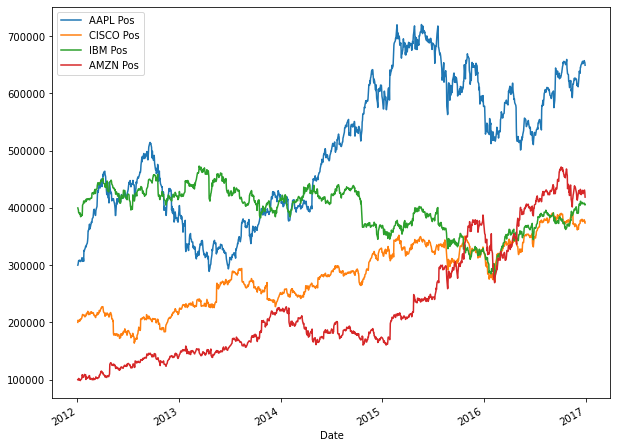

In [54]:
portfolio_val.drop('Total Pos', axis=1).plot(kind='line', figsize=(10,8))

Text(0.5, 1.0, 'Total Portfolio Value')

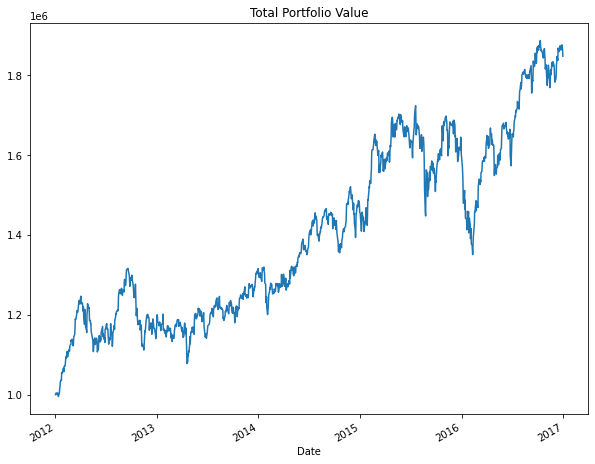

In [55]:
portfolio_val['Total Pos'].plot(figsize=(10,8))
plt.title('Total Portfolio Value')

# Portfolio Statistics

In [56]:
portfolio_val['Daily Return'] = portfolio_val['Total Pos'].pct_change(1)

In [57]:
cum_ret = 100 * (portfolio_val['Total Pos'][-1] / portfolio_val['Total Pos'][0] -1)
print('Our return was {}%'.format(cum_ret))

Our return was 84.74285181665545%


In [58]:
SR = portfolio_val['Daily Return'].mean() / portfolio_val['Daily Return'].std()

In [61]:
print("Annulized Sharpe Ratio: " + str((252**0.5)*SR))

Annulized SR: 0.8174864618859096


# Portfolio Optimization

In [66]:
stocks = pd.concat([aapl,cisco,ibm,amzn], axis=1)
stocks.columns = ['aapl','cisco','ibm','amzn']

In [70]:
mean_daily_ret = stocks.pct_change(1).mean()
stocks.pct_change(1).corr()

,aapl,cisco,ibm,amzn
aapl,1.000000,0.301990,0.297498,0.235487
cisco,0.301990,1.000000,0.424672,0.284470
ibm,0.297498,0.424672,1.000000,0.258492
amzn,0.235487,0.284470,0.258492,1.000000


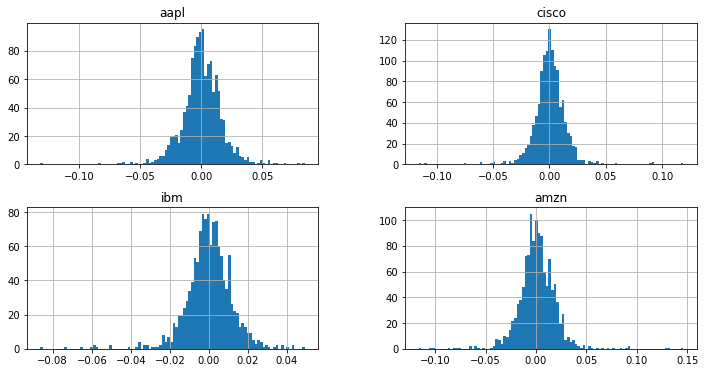

In [74]:
log_ret = np.log(stocks/stocks.shift(1))
log_ret.hist(bins=100, figsize=(12,6))

# Monte Carlo Simulation

In [92]:
np.random.seed(101)
num_ports = 25000

all_weights = np.zeros((num_ports,len(stocks.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for ind in range(num_ports):

    weights = np.array(np.random.random(4))
    weights = weights / np.sum(weights)
    all_weights[ind,:] = weights

    ret_arr[ind] = np.sum((log_ret.mean() * weights) *252)
    vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))

    sharpe_arr[ind] = ret_arr[ind] / vol_arr[ind]

print('Max Sharpe Ratio: ' + str(sharpe_arr.max()))

Max Sharpe Ratio: 1.0303260551271316


Text(0, 0.5, 'Return')

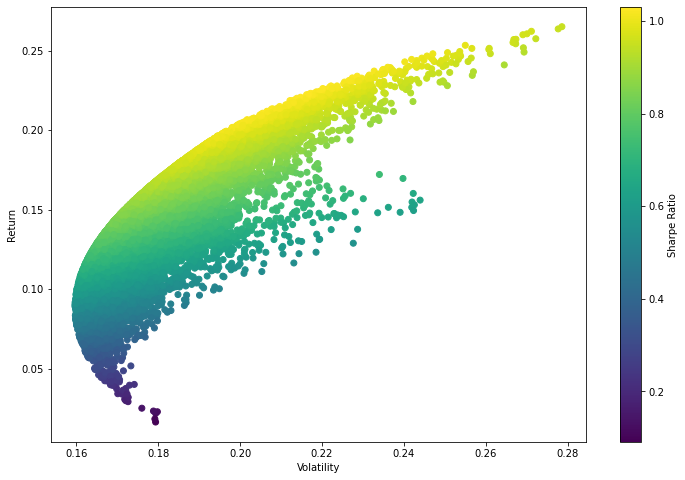

In [99]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

# Calculated using Optimization Solver

In [111]:
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
    sr = ret / vol
    return np.array([ret,vol,sr])

def neg_sharpe(weights):
    return  get_ret_vol_sr(weights)[2] * -1

def check_sum(weights):
    return np.sum(weights) - 1

def minimize_volatility(weights):
    return  get_ret_vol_sr(weights)[1] 

In [112]:
cons = ({'type':'eq','fun': check_sum})
bounds = ((0, 1), (0, 1), (0, 1), (0, 1))
init_guess = [0.25,0.25,0.25,0.25]

In [118]:
opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
get_ret_vol_sr(opt_results.x)

array([0.28715299, 0.30735923, 0.93425855])

In [114]:
frontier_y = np.linspace(0,0.3,100)
frontier_volatility = []

for possible_return in frontier_y:
    cons = ({'type':'eq','fun': check_sum},
            {'type':'eq','fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = minimize(minimize_volatility, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
    frontier_volatility.append(result['fun'])

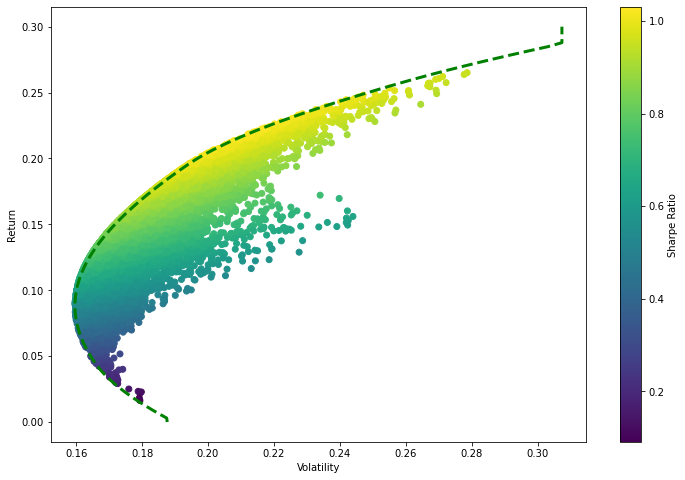

In [116]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

plt.plot(frontier_volatility,frontier_y,'g--',linewidth=3)